# Crime Severity Data

## This notebook processes Crime Severity Index (CSI) data from StatCan
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510002601

In [1]:
from functions import parameters as p
from functions import crime_severity as cs
from functions import statcan_data as sd



project_parameters = p.Project_Parameters()

In [2]:
params_download_crime_severity_data = {
    'project_parameters': project_parameters,
    'data_key': 'crime_severity',
}

status_csi = sd.download_statcan_data(params_download_crime_severity_data)
zipfilename = status_csi.get('zipfilename', None)

In [3]:
params_read_crime_severity_data = {
    'project_parameters': project_parameters,
    'filename': zipfilename,
    'is_zipped': True,
}

status_rcsi = cs.read_crime_severity_data(params_read_crime_severity_data)

In [4]:
df = status_rcsi.get('value', None)
display(df.head(50))
df.info()
display(df.describe(include="all"))

,REF_DATE,GEO,DGUID,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1998,Canada,2021A000011124,Crime severity index,Index,160,units,0,v44312461,1.10,118.84,NaN,NaN,NaN,2
1,1998,Canada,2021A000011124,Violent crime severity index,Index,160,units,0,v44312463,1.30,97.80,NaN,NaN,NaN,2
2,1998,Canada,2021A000011124,Non-violent crime severity index,Index,160,units,0,v44312465,1.50,126.93,NaN,NaN,NaN,2
3,1998,Canada,2021A000011124,Youth crime severity index,Index,160,units,0,v53079455,1.70,110.24,NaN,NaN,NaN,2
4,1998,Canada,2021A000011124,Youth violent crime severity index,Index,160,units,0,v53079457,1.90,86.59,NaN,NaN,NaN,2
5,1998,Canada,2021A000011124,Youth non-violent crime severity index,Index,160,units,0,v53079447,1.11,128.25,NaN,NaN,NaN,2
6,1998,Canada,2021A000011124,Weighted clearance rate,Number,223,units,0,v53079449,1.13,34.06,NaN,NaN,NaN,2
7,1998,Canada,2021A000011124,Violent weighted clearance rate,Number,223,units,0,v53079451,1.15,55.66,NaN,NaN,NaN,2
8,1998,Canada,2021A000011124,Non-violent weighted clearance rate,Number,223,units,0,v53079453,1.17,27.66,NaN,NaN,NaN,2
9,1998,Canada,2021A000011124,Percent change in non-violent weighted clearan...,Percent,239,units,0,v53079454,1.18,NaN,..,NaN,NaN,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REF_DATE       21900 non-null  int64  
 1   GEO            21900 non-null  object 
 2   DGUID          21900 non-null  object 
 3   Statistics     21900 non-null  object 
 4   UOM            21900 non-null  object 
 5   UOM_ID         21900 non-null  int64  
 6   SCALAR_FACTOR  21900 non-null  object 
 7   SCALAR_ID      21900 non-null  int64  
 8   VECTOR         21900 non-null  object 
 9   COORDINATE     21900 non-null  float64
 10  VALUE          17532 non-null  float64
 11  STATUS         4368 non-null   object 
 12  SYMBOL         0 non-null      float64
 13  TERMINATED     0 non-null      float64
 14  DECIMALS       21900 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 2.5+ MB


,REF_DATE,GEO,DGUID,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
count,21900.000000,21900,21900,21900,21900,21900.000000,21900,21900.0,21900,21900.000000,17532.000000,4368,0.0,0.0,21900.0
unique,NaN,56,56,18,3,NaN,1,NaN,1008,NaN,NaN,1,NaN,NaN,NaN
top,NaN,Canada,2021A000011124,Crime severity index,Percent,NaN,units,NaN,v44312461,NaN,NaN,..,NaN,NaN,NaN
freq,NaN,460,460,1267,10497,NaN,21900,NaN,26,NaN,NaN,4368,NaN,NaN,NaN
mean,2011.824840,NaN,NaN,NaN,NaN,208.800274,NaN,0.0,NaN,25.739967,38.682262,NaN,NaN,NaN,2.0
std,7.215787,NaN,NaN,NaN,NaN,36.039757,NaN,0.0,NaN,14.807527,64.398984,NaN,NaN,NaN,0.0
min,1998.000000,NaN,NaN,NaN,NaN,160.000000,NaN,0.0,NaN,1.100000,-56.750000,NaN,NaN,NaN,2.0
25%,2006.000000,NaN,NaN,NaN,NaN,160.000000,NaN,0.0,NaN,13.120000,0.000000,NaN,NaN,NaN,2.0
50%,2012.000000,NaN,NaN,NaN,NaN,223.000000,NaN,0.0,NaN,25.250000,17.165000,NaN,NaN,NaN,2.0
75%,2018.000000,NaN,NaN,NaN,NaN,239.000000,NaN,0.0,NaN,37.900000,61.790000,NaN,NaN,NaN,2.0


# Basic plots

<AxesSubplot:xlabel='REF_DATE'>

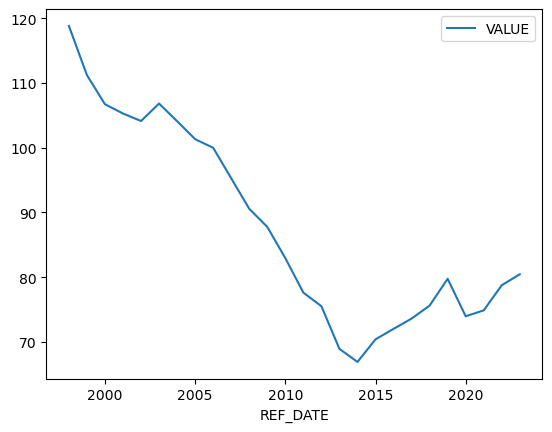

In [7]:
pdf = df[['REF_DATE', 'GEO', 'Statistics', 'VALUE']]

# Canada
pdf = pdf[(pdf['GEO'] == 'Canada') & (pdf['Statistics'] == 'Crime severity index')]

pdf = pdf.sort_values(by='REF_DATE')
pdf = pdf.set_index('REF_DATE')
pdf.plot()